## Computable Phenotype Generation for Congestive Heart Failure and Utilization of Machine learning clustering method to analyse the comorbidity among the clusters.


**Cohort Definition:
We are using De-identified MIMIC database to select our cohort**

- Incldes all patients with condition diagnosis of Congestive Heart Failure
- Includes all patients with age 50 or more
- Patients must have 2 ore more visits on records
- Patient must have systolic and diastolic bp values on records( can not be null)


**We also gathered other variables required for our analysis**

-  Created pathway1 : patients who takes lisinopril as ingredient noted as 1, otherwise 0
-  Gathered patient's age, gender, maximum weight(in Kg)
-  Created pathway : Patient who is alive denoted as 1, dead denoted as 0
-  Created diabetes pathway:  Patient who has diabetes as condtion denoted as 1, otherwise 0
-  Created hypertention pathway:  Patient who has hypertention denoted as 1, otherwise  0
-  Created hyperlipidemia pathway: Patient who has hyperlipidemai denoted as 1, otherwise 0

In [71]:
import os
import sqlalchemy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [72]:
# Creates inline plots
%matplotlib inline

# Saves the notebook on a set time interval (15 seconds in this case)
%autosave 15 

Autosaving every 15 seconds


In [73]:
myUserName = "chipstudent9"
myPassword = "UaTuHh1H2Jt9"

server_url = "mimic-db.renci.unc.edu"
database = "mimic"

# Create Connection String
conn_str = f"{myUserName}:{myPassword}@{server_url}/{database}"

# Create Engine
engine = sqlalchemy.create_engine('postgresql://' + conn_str)

In [74]:
# query =  """
#         select count(*) from omop.person
#         """ 

# pd.read_sql_query(query, engine)

In [75]:
query1 ="""

--Developing computable phenotyping of Congestive Heart Failure
--finding concept_id for congestive heart failure
with 
nonstandchf as (
select c.*
from omop.concept c
where c.concept_code LIKE 'I50%' and c.domain_id = 'Condition'
),

--finds the related codes 
relationships as (
select *
from omop.concept_relationship cr JOIN nonstandchf nstd ON cr.concept_id_1 = nstd.concept_id	
where cr.relationship_id = 'Maps to'
),

--grabs standard codes for CHF
stdchf as (
select c.*
from omop.concept c JOIN relationships r ON c.concept_id= r.concept_id_2
where c.standard_concept = 'S'
),
	
--finding distinct patient id related to condition concept id of congestive heart fialure
pidchf as (
select distinct co.person_id
from omop.condition_occurrence co
join stdchf s on co.condition_concept_id = s.concept_id

),

-- find patient id where age is 50 or more on anyday of visit
agepid as (
select distinct p.person_id
from pidchf p
where p.person_id in (select vo.person_id
		from omop.visit_occurrence vo
		join omop.person p1 on p1.person_id = vo.person_id
		where EXTRACT(year FROM age(vo.visit_start_date,p1.birth_datetime)) >= 50)

),

-- patient should have at least 2 visits on record
patient_id as (
select distinct vo.person_id 
from omop.visit_occurrence vo
join agepid a on a.person_id = vo.person_id
group by vo.person_id
having count(distinct(vo.visit_start_date))>=2

),

-- finding systlic blood pressure (if blood pressure is null, we do not include them in cohort)
systolic_bp as (
select distinct pid.person_id, max ( m.value_as_number) as systolic_bp
from patient_id pid
join omop.measurement m on m.person_id = pid.person_id
where m.measurement_concept_id in ('3004249','3018586', '3035856','3009395')
group by pid.person_id
),

--finding diastolic blood pressure (if blood pressure is null, we do not include them in cohort)
diastolic_bp as (
select distinct sbp.person_id, max (m.value_as_number ) as diastolic_bp
from systolic_bp sbp
join omop.measurement m on m.person_id = sbp.person_id
where m.measurement_concept_id in ('3012888', '3034703', '3019962', '3013940')
group by sbp.person_id
),

-- -- we used following query to find out concept id for lisinopril as ingredient
-- -- select *
-- -- from omop.concept c
-- -- where lower(c.concept_name) = 'lisinopril' and lower(c.concept_class_id) like '%ingre%' ;

-- --This search will try to find any other concept_id maps to my finding, we found same concept id
-- -- SELECT *
-- -- FROM omop.concept_relationship c
-- -- WHERE c.concept_id_1 = 1308216
-- -- AND c.relationship_id = 'Maps to';

--This will help us to find all the drugs(children) that has ingredient(parent) as lisinopril
lisinoprilchild as (
select a.max_levels_of_separation , c.*
from omop.concept_ancestor a
join omop.concept c on c.concept_id = a.descendant_concept_id 
	where a.ancestor_concept_id = 1308216 --ingredient is always set as parent(ancestor)
order by a.max_levels_of_separation
	),

-- This will help us narrowdown patient's id who has lisinopril as ingredient 
allpiddrug as (
select de.*
from omop.drug_exposure de
join lisinoprilchild lc on lc.concept_id = de.drug_concept_id
),

--This pathways indicates if patient takes lisinopril as ingredient then 1, otherwise 0
pathway1 as (
select distinct pid.person_id , pid.diastolic_bp,
	case when dr.person_id is null
	then '0'
	else '1'
	end as pathway1
from diastolic_bp pid
left join allpiddrug dr on dr.person_id = pid.person_id
),

--connect bp , lisinopril in one table
allbp as (
select pid.person_id,pid.pathway1,pid.diastolic_bp,sbp.systolic_bp
from pathway1 pid
join systolic_bp sbp on sbp.person_id = pid.person_id

),
-------------------------------------------------------------------
-- Upto this point , we have all our chohort.  Now we will gather some more criteria for our analysis from database
-- So far we have 3154 rows 
-- --get age of all patient who are 50 and older in database 
-- --there are multiple age for same patient- selected max age of patient in database

all_age as (
select distinct vo.person_id, max(EXTRACT(year FROM age(vo.visit_start_date,p1.birth_datetime)))as age
from omop.visit_occurrence vo 
join omop.person p1 on p1.person_id = vo.person_id
where EXTRACT(year FROM age(vo.visit_start_date,p1.birth_datetime)) >= 50
	group by vo.person_id

),
-- -- get age of our patient 
pathway4 as (
select pid.*, a_age.age
from allbp pid
left join all_age a_age on a_age.person_id = pid.person_id
),

-- --get gender concept
gender_concept as (
select c.concept_name, c.concept_id
from omop.concept c
where lower(c.domain_id) = 'gender'
and c.standard_concept = 'S'
) ,

--get gender for our patients
pathway5 as (
select pid.*, gc.concept_name as gender
from pathway4 pid
left join omop.person p on p.person_id = pid.person_id
join gender_concept gc on gc.concept_id = p.gender_concept_id
),

-- --get the concept id for body weight
weight_concept as(
select c.*
from omop.concept c
where lower(c.concept_name) like 'body weight'
and c.standard_concept = 'S'
and lower(c.domain_id) = 'measurement'
) ,

-- get weight in KG for our patients
weight as (
select pid.person_id ,round (max (m.value_as_number),2)as weight
from pathway5 pid 
left join omop.measurement m on m.person_id = pid.person_id
join weight_concept wc on wc.concept_id = m.measurement_concept_id
group by pid.person_id
),

pathway6 as  (
select pid.*, w.weight
from pathway5 pid
left join weight w on w.person_id = pid.person_id
),

--find patient is alive or deceased,  
pathway7 as (
select pid.*, 
case when d.person_id is null
then '1'
else '0'
end as dead_alive
from pathway6 pid
left join omop.death d on d.person_id = pid.person_id
),

-------------------------------------------------------------------------

-- Next goal to see if our cohart of patient has diabetes or not
--find concept_id for diabetes only
nonstd_diabetes as (
select c.*
from omop.concept c
where ( c.concept_code LIKE 'E10%' or c.concept_code LIKE 'E11%') and c.domain_id = 'Condition'
),

--finds the related codes 
relationships_d as (
select *
from omop.concept_relationship cr JOIN nonstd_diabetes non_d ON cr.concept_id_1 = non_d.concept_id	
where cr.relationship_id = 'Maps to'
),

--grabs standard codes for diabetes (we get 365 codes for diabetes type 1 and type 2)
std_diabetes as (
select c.*
from omop.concept c JOIN relationships_d r ON c.concept_id= r.concept_id_2
where c.standard_concept = 'S'
),

-- lets join patient on concept id for patient and concept id of diabetes 
--finding all condtions id for patient
allcondition as (
select pid.*, co.condition_concept_id --(pid.person_id, pid.pathway1, pid.diastolic_bp,pid.systolic_bp, pid.age,pid.gender, pid.weight,pid.dead_alive)
from pathway7 pid
Inner join omop.condition_occurrence co on co.person_id = pid.person_id
),

--this table will join concept id from diabetes and concept id from cohart patient
diabetes_1 as (
select distinct ac.person_id, sd.concept_id, ac.condition_concept_id
from allcondition ac 
join std_diabetes sd on sd.concept_id = ac.condition_concept_id
 and ac.condition_concept_id in (sd.concept_id)
),

--get patient_id and diabetes with switch case
--This table gives output of only patient with diabetes
diabetes_2 as (
select distinct d.person_id, 
case when d.concept_id is null
	then 'No diabetes'
	else 'Yes diabetes'
	end as diabetes
from diabetes_1 d
),


--This is to join with orignal table 
diabetes_pathway as (
select distinct ac.person_id, ac.pathway1, ac.diastolic_bp,ac.systolic_bp, ac.age,ac.gender, ac.weight,ac.dead_alive,
case when dp.diabetes is null
then '0'
else '1'
end as diabetes_pathway
from allcondition ac
left join diabetes_2 dp on dp.person_id = ac.person_id
),
--------------------------------------------------------------------------

-- Next goal to see if our cohart of patient has essential hypertention or not
--find concept_id for essential hypertention only
nonstd_hypertention as (
select c.*
from omop.concept c
where ( c.concept_code LIKE 'I10%' or c.concept_code LIKE 'I11%') and c.domain_id = 'Condition'
),

--finds the related codes 
relationships_h as (
select *
from omop.concept_relationship cr JOIN nonstd_hypertention non_h ON cr.concept_id_1 = non_h.concept_id	
where cr.relationship_id = 'Maps to'
),

--grabs standard codes for hypertention
std_hypertention as (
select c.*
from omop.concept c JOIN relationships_h r ON c.concept_id= r.concept_id_2
where c.standard_concept = 'S'
),

--this table will join concept id from diabetes and concept id from cohart patient
hypertention_1 as (
select distinct ac.person_id, sh.concept_id, ac.condition_concept_id
from allcondition ac 
join std_hypertention sh on sh.concept_id = ac.condition_concept_id
 and ac.condition_concept_id in (sh.concept_id)
),

--get patient_id and diabetes with switch case
hypertention_2 as (
select distinct d.person_id, 
case when d.concept_id is null
	then 'No hypertention'
	else 'Yes hypertention'
	end as hypertention
from hypertention_1 d
),

--This is to join with orignal table 
hypertention_pathway as (
select distinct dp.person_id, dp.pathway1, dp.diastolic_bp,dp.systolic_bp, dp.age,dp.gender, dp.weight,dp.dead_alive,dp.diabetes_pathway,
case when hp.hypertention is null
then '0'
else '1'
end as hypertention_pathway
from diabetes_pathway dp
left join hypertention_2 hp on hp.person_id = dp.person_id
),
------------------------------------------------------------

-- Next goal to see if our cohart of patient has hyperlipidemia or not
--find concept_id for hyperlipidemia only
nonstd_hyperlipidemia as (
select c.*
from omop.concept c
where ( c.concept_code LIKE 'E78%') and c.domain_id = 'Condition'
),

--finds the related codes 
relationships_hy as (
select *
from omop.concept_relationship cr JOIN nonstd_hyperlipidemia non_h ON cr.concept_id_1 = non_h.concept_id	
where cr.relationship_id = 'Maps to'
),

--grabs standard codes for hyperlipidemia
std_hyperlipidemia as (
select c.*
from omop.concept c JOIN relationships_hy r ON c.concept_id= r.concept_id_2
where c.standard_concept = 'S'
),

--this table will join concept id from hyperlipidemia and concept id from cohart patient
hyperlipidemia_1 as (
select distinct ac.person_id, shl.concept_id, ac.condition_concept_id
from allcondition ac 
join std_hyperlipidemia shl on shl.concept_id = ac.condition_concept_id
 and ac.condition_concept_id in (shl.concept_id)
),

--get patient_id and hyperlipidemia with switch case
hyperlipidemia_2 as (
select distinct d.person_id, 
case when d.concept_id is null
	then 'No hyperlipidemia'
	else 'Yes hyperlipidemia'
	end as hyperlipidemia
from hyperlipidemia_1 d
)

--This is to join with orignal table 
--hypertention_pathway as (
select distinct dp.person_id, dp.pathway1, dp.diastolic_bp,dp.systolic_bp, dp.age,dp.gender, dp.weight,dp.dead_alive,dp.diabetes_pathway, dp.hypertention_pathway,
case when hp.hyperlipidemia is null
then '0'
else '1'
end as hyperlipidemia_pathway
from hypertention_pathway dp
left join hyperlipidemia_2 hp on hp.person_id = dp.person_id
--),


"""
chf_1 = pd.read_sql_query(sqlalchemy.text(query1),engine)

In [76]:
# for conviniece purposes, while I do my analysis, I have created csv file which we will read , insted of running whole query
#chf_1 = pd.read_csv('chf_phenotype.csv')

### Check the overall datafram looks like and validate our cohar by checking number of unique rows and not null values 

In [77]:
#chf_1 = pd.read_csv('heartfail_march18_withoutcondition.csv')
chf_1.head()

,person_id,pathway1,diastolic_bp,systolic_bp,age,gender,weight,dead_alive,diabetes_pathway,hypertention_pathway,hyperlipidemia_pathway
0,392775850,1,89.0,169.0,81.0,FEMALE,98.0,1,0,0,1
1,392775872,1,111.0,195.0,66.0,MALE,56.0,1,0,1,1
2,392775881,1,107.0,185.0,79.0,FEMALE,55.0,0,0,1,0
3,392775886,0,82.0,142.0,85.0,FEMALE,59.9,0,0,1,0
4,392775894,1,107.0,193.0,56.0,FEMALE,148.9,1,1,1,1


In [78]:
chf_1.describe()

,person_id,diastolic_bp,systolic_bp,age,weight
count,3.154000e+03,3154.000000,3154.000000,3154.000000,3125.000000
mean,3.927975e+08,458.542188,257.425193,93.524096,91.119706
std,1.309188e+04,4595.702868,3090.737548,67.627721,43.790892
min,3.927758e+08,52.000000,105.000000,50.000000,1.000000
25%,3.927863e+08,91.000000,156.000000,65.000000,71.000000
50%,3.927965e+08,103.000000,174.000000,75.000000,84.500000
75%,3.928084e+08,123.000000,194.000000,83.000000,101.000000
max,3.928224e+08,91099.980000,141146.040000,311.000000,1410.000000


In [79]:
# We can varifies that all patients are unique.  Our total number of row count and unique patient's id are same
chf_1.loc[:,'person_id'].nunique()

3154

In [80]:
# This will also varifies that our systolic and diastolic columns does not have any null values
chf_1.isnull().any()

person_id                 False
pathway1                  False
diastolic_bp              False
systolic_bp               False
age                       False
gender                    False
weight                     True
dead_alive                False
diabetes_pathway          False
hypertention_pathway      False
hyperlipidemia_pathway    False
dtype: bool

In [81]:
# Will drop null values from weight columns (null values causes error while ploting graph as our analysis does not requred null values in weight)
chf_1.dropna(axis=0)
# Now we are down to 3125 rows for our analysis

,person_id,pathway1,diastolic_bp,systolic_bp,age,gender,weight,dead_alive,diabetes_pathway,hypertention_pathway,hyperlipidemia_pathway
0,392775850,1,89.0,169.0,81.0,FEMALE,98.00,1,0,0,1
1,392775872,1,111.0,195.0,66.0,MALE,56.00,1,0,1,1
2,392775881,1,107.0,185.0,79.0,FEMALE,55.00,0,0,1,0
3,392775886,0,82.0,142.0,85.0,FEMALE,59.90,0,0,1,0
4,392775894,1,107.0,193.0,56.0,FEMALE,148.90,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
3149,392822241,1,135.0,198.0,78.0,MALE,81.60,0,0,1,1
3150,392822327,0,91.0,128.0,87.0,MALE,67.00,0,0,1,0
3151,392822329,0,135.0,188.0,85.0,FEMALE,47.50,1,0,1,0
3152,392822338,1,175.0,182.0,76.0,FEMALE,107.95,1,0,1,1


## Step1:  Clean the data, Find out outlier with traditional method and remove them

 **In order to apply traditional method of 3 standard deviation, distribtuion must be normal.  Once we have normal distribution, we can apply probability density function, where 99.7% of population falls withing three standard deviation limit and outide this range datapoints are our outliers.** 

* Variables are diastolic blood pressure, systolic blood pressure, age, weight  
* Let's check if the the distribution is normal or not.

/Users/mansishah/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/mansishah/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


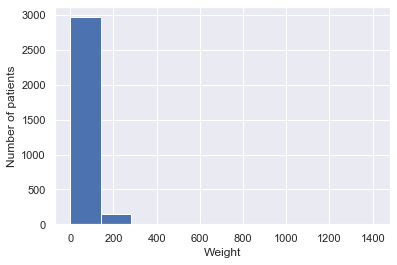

<Figure size 432x288 with 0 Axes>

In [82]:
# Weight histogram to see the distribution 
plt.hist(chf_1.weight)
plt.xlabel('Weight')
plt.ylabel('Number of patients')
plt.title= ('Distribution of Weight among patient cohort')
plt.show()
# And this is how you can save a figure that you have created
plt.gcf().savefig('weight_histogram_unclean.png')
#
# It is good to define difference betweeen outlier and manual error!!!


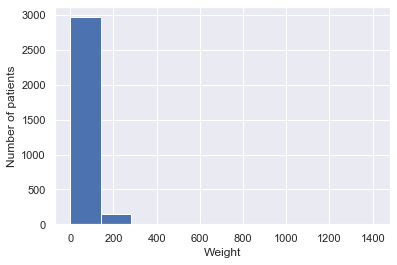

<Figure size 432x288 with 0 Axes>

In [83]:
# Set the threshold for weight 
x1_values_unclean = chf_1.loc[:,'weight']
# droping rows with weight value is unrealistic
chf_2 = chf_1.drop(chf_1[chf_1.weight >=400].index)
# also remove null values
chf_2 =chf_1.dropna()
x1_values_clean = chf_2.loc[:,'weight']

plt.hist(x1_values_clean)
plt.xlabel('Weight')
plt.ylabel('Number of patients')
plt.title= ('Distribution of weight among patient cohort')
plt.show()
plt.gcf().savefig('weight_histogram_clean.png')

In [84]:
chf_2.shape
# we have droped thoes rows from our dataset.  
# Before we move on with our analysis plan; Let's find out any unrealistic manual error with other variables


(3125, 11)

* Systolic Blood pressure : histogram, remove manual error, check distribution, check number of rows 


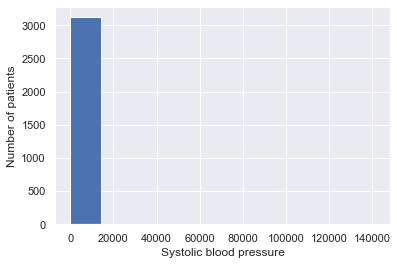

<Figure size 432x288 with 0 Axes>

In [15]:
plt.hist(chf_2.systolic_bp)
plt.xlabel('Systolic blood pressure')
plt.ylabel('Number of patients')
plt.title= ('Distribution of systolic blood pressure among patient cohort')
plt.show()
plt.gcf().savefig('Systolic_histogram_unclean.png')

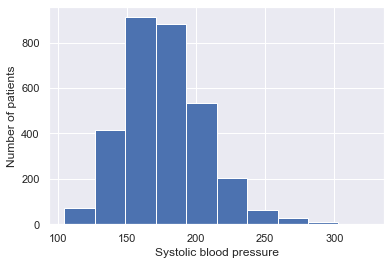

<Figure size 432x288 with 0 Axes>

In [16]:
chf_3 = chf_2.drop(chf_2[chf_2.systolic_bp >400].index)
plt.hist(chf_3.systolic_bp)

plt.xlabel('Systolic blood pressure')
plt.ylabel('Number of patients')
plt.title= ('Distribution of Systolic blood pressure among patient cohort')
plt.show()
plt.gcf().savefig('Systolic_histogram_clean.png')

In [17]:
chf_3.shape
# we are now down to 3144 rows in our dataset

(3119, 11)

**Check distribution of diastolic blood pressure, set limits to remove manual error and remove them**

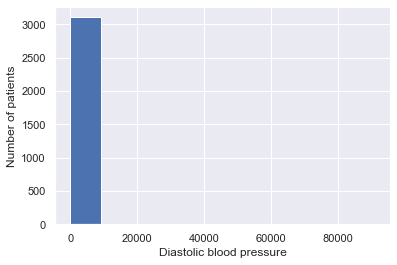

<Figure size 432x288 with 0 Axes>

In [18]:
plt.hist(chf_3.diastolic_bp)
plt.xlabel('Diastolic blood pressure')
plt.ylabel('Number of patients')
plt.title= ('Distribution of Diastolic blood pressure among patient cohort')
plt.show()
plt.gcf().savefig('diastolic_histogram_unclean.png')

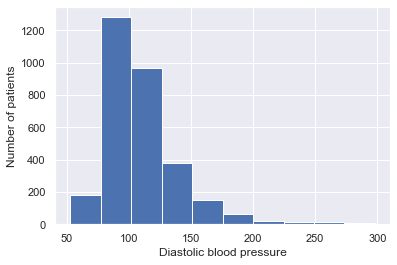

<Figure size 432x288 with 0 Axes>

In [19]:
# remove manual error from diastolic_bp 
chf_4 = chf_3.drop(chf_3[chf_3.diastolic_bp >400].index)
plt.hist(chf_4.diastolic_bp)
plt.xlabel('Diastolic blood pressure')
plt.ylabel('Number of patients')
plt.title= ('Distribution of Diastolic blood pressure among patient cohort')
plt.show()
chf_4.shape
plt.gcf().savefig('diastolic_histogram_clean.png')

**Check Distribution of age, set limit , remove manual error datapoints**

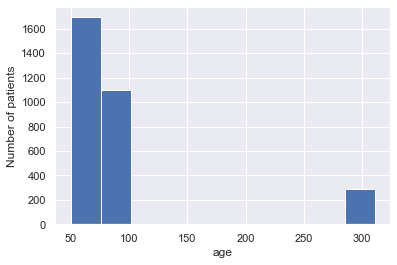

<Figure size 432x288 with 0 Axes>

In [20]:
plt.hist(chf_4.age)
plt.xlabel('age')
plt.ylabel('Number of patients')
plt.title= ('Distribution of age among patient cohort')
plt.show()
plt.gcf().savefig('age_histogram_unclean.png')

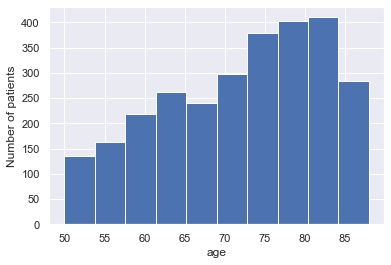

<Figure size 432x288 with 0 Axes>

In [21]:
#removing unrealistic age 
chf_5 = chf_4.drop(chf_4[chf_4.age >120].index)
plt.xlabel('age')
plt.ylabel('Number of patients')
plt.title= ('Distribution of age among patient cohort')
plt.hist(chf_5.age)
plt.show()
plt.gcf().savefig('age_histogram_clean.png')




## We have now our datafram chf_5 which is manual error free and ready for outlier detection with traditional method

- Variables: Weight, Systolic blood pressure, Diastolic blood pressure

In [22]:
from scipy.stats import norm
import numpy as np

In [23]:
# setting upper and lower limit of 3 standard deviation for weight
UL_weight = chf_5.weight.mean() + (3 * chf_5.weight.std())
LL_weight = chf_5.weight.mean() - (3 * chf_5.weight.std())
# setting upper and lower limit of 3 Standard deviation for systilic blood pressure
UL_systolic_bp = chf_5.systolic_bp.mean() + (3 * chf_5.systolic_bp.std())
LL_systolic_bp = chf_5.systolic_bp.mean() - (3 * chf_5.systolic_bp.std())
# setting upper and lower limit of 3 Standard Daviation for Diastolic blood pressure
UL_diastolic_bp = chf_5.diastolic_bp.mean() + (3 * chf_5.diastolic_bp.std())
LL_diastolic_bp = chf_5.diastolic_bp.mean() - (3 * chf_5.diastolic_bp.std())

In [24]:
chf_3sd_removal =chf_5[(chf_5.weight >UL_weight) | (chf_5.weight < LL_weight)|(chf_5.systolic_bp > UL_systolic_bp) |(chf_5.systolic_bp < LL_systolic_bp)|(chf_5.diastolic_bp > UL_diastolic_bp) | (chf_5.diastolic_bp < LL_diastolic_bp)]

In [25]:
chf_3sd_removal.shape
# we found 114 patients who are dectected as outlier in our chf_5 database with 3sd method.

(82, 11)

In [26]:
# This step will remove outlier and leave us with without outlier dataframe we will call df_1
df_1=pd.concat([chf_5, chf_3sd_removal, chf_3sd_removal]).drop_duplicates(keep=False)

In [27]:
df_1.info()
df_1.isnull().any()
df_1.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2707 entries, 0 to 3153
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   person_id               2707 non-null   int64  
 1   pathway1                2707 non-null   int64  
 2   diastolic_bp            2707 non-null   float64
 3   systolic_bp             2707 non-null   float64
 4   age                     2707 non-null   int64  
 5   gender                  2707 non-null   object 
 6   weight                  2707 non-null   float64
 7   dead_alive              2707 non-null   int64  
 8   diabetes_pathway        2707 non-null   int64  
 9   hypertention_pathway    2707 non-null   int64  
 10  hyperlipidemia_pathway  2707 non-null   int64  
dtypes: float64(3), int64(7), object(1)
memory usage: 253.8+ KB


(2707, 11)

### K-Medoids clustering methods to create clusters


In [28]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn_extra.cluster import KMedoids

In [29]:
# included all numeric variable for this method
# so we need extract those varaibles from our chf_5 datafram and create new datafram to pass in kemans method
cl_df1 = pd.DataFrame().assign(cl_weight=df_1['weight'], cl_systolic_bp=df_1['systolic_bp'], cl_diastolic_bp =df_1['diastolic_bp'],cl_age=df_1['age'], cl_lisinopril=df_1['pathway1'], cl_dead_alive=df_1['dead_alive'], cl_diabetes=df_1['diabetes_pathway'], cl_hypertention=df_1['hypertention_pathway'],cl_hyperlipidemia=df_1['hyperlipidemia_pathway'] )
cl_df1.head()
cl_df1.isnull().any()
cl_df1.shape



(2707, 9)

In [30]:
# we need to scale data set so all data in similar range
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(cl_df1)
cl_df1_std = sc.transform(cl_df1)
print(cl_df1_std)
cl_df1_std.shape


[[ 0.27686077 -0.23198583 -0.75896039 ... -0.39101929 -1.20314537
   1.01451239]
 [-1.28144373  0.7411131   0.11743328 ... -0.39101929  0.83115476
   1.01451239]
 [-1.31854622  0.36684428 -0.04191102 ... -0.39101929  0.83115476
  -0.98569521]
 ...
 [-1.59681488  0.47912493  1.0734991  ... -0.39101929  0.83115476
  -0.98569521]
 [ 0.64603052  0.25456363  2.66694214 ... -0.39101929  0.83115476
   1.01451239]
 [-0.91041885  0.29199051 -0.32076356 ... -0.39101929  0.83115476
   1.01451239]]


(2707, 9)

In [31]:
kmedoids = KMedoids(n_clusters=6, 
            method='alternate', 
            init='k-medoids++')



In [32]:

clusters = kmedoids.fit_predict(cl_df1_std)
print(clusters)
len(clusters)

[5 5 2 ... 5 4 5]


2707

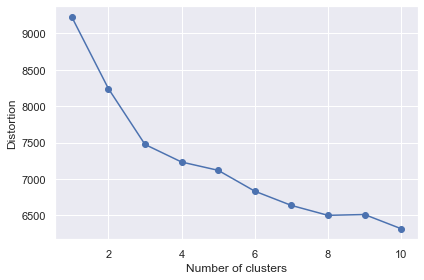

[9226.783367491149, 8242.128883039104, 7474.058164391191, 7232.278805911815, 7118.233813405281, 6831.568328690057, 6635.697894284573, 6499.348128837424, 6510.546454058952, 6315.324446054483]


<Figure size 432x288 with 0 Axes>

In [33]:
# applied elbow method to find most efficient number of clusters
distortions = []
for i in range(1, 11):
    km = KMedoids(n_clusters=i, 
                init='k-medoids++', 
                 method='alternate')
    km.fit(cl_df1_std)
    distortions.append(km.inertia_)
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
#plt.savefig('figures/10_03.png', dpi=300)
plt.show()
plt.gcf().savefig('Elbow_method.png')
print(distortions)

In [34]:
df_1["clusters"] = clusters


In [35]:
df_1.head()

,person_id,pathway1,diastolic_bp,systolic_bp,age,gender,weight,dead_alive,diabetes_pathway,hypertention_pathway,hyperlipidemia_pathway,clusters
0,392775850,1,89.0,169.0,81,FEMALE,98.0,1,0,0,1,5
1,392775872,1,111.0,195.0,66,MALE,56.0,1,0,1,1,5
2,392775881,1,107.0,185.0,79,FEMALE,55.0,0,0,1,0,2
3,392775886,0,82.0,142.0,85,FEMALE,59.9,0,0,1,0,1
4,392775894,1,107.0,193.0,56,FEMALE,148.9,1,1,1,1,3


## Make Table#1 Summary

In [36]:
df_1.groupby(['clusters'])['person_id'].agg(['count'])
# this will give n value for each cluster

,count
clusters,
0,397
1,641
2,573
3,262
4,272
5,562


In [37]:
df_1.groupby(['clusters','gender'])['person_id'].agg(['count'])
# this will give count by gender


count
clusters gender       
0        FEMALE    174
         MALE      223
1        FEMALE    294
         MALE      347
2        FEMALE    256
         MALE      317
3        FEMALE    113
         MALE      149
4        FEMALE    131
         MALE      141
5        FEMALE    249
         MALE      313

In [38]:
df_1.groupby(['clusters'])['diastolic_bp','systolic_bp','weight'].agg(['mean','std'])


/Users/mansishah/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


diastolic_bp            systolic_bp                 weight           
                 mean        std        mean        std        mean        std
clusters                                                                      
0           99.662469  17.529108  166.919395  23.893990   91.404383  27.089813
1          102.951638  19.746103  172.341654  24.487311   88.581622  25.574660
2          108.308901  24.648236  176.776614  27.062393   85.060558  23.415763
3          108.229008  22.881860  182.022901  24.729794   96.506145  28.884489
4          145.500000  27.735972  200.602941  23.075931  109.508346  34.864242
5          101.327402  18.425055  167.218861  24.705541   85.778078  21.385097

In [39]:
df_1.groupby(['clusters','diastolic_bp','systolic_bp','weight']).agg(['mean','std'])

person_id     pathway1      age      \
                                               mean std     mean std mean std   
clusters diastolic_bp systolic_bp weight                                        
0        55.0         121.0       55.4    392808555 NaN        0 NaN   78 NaN   
         64.0         114.0       110.3   392786402 NaN        0 NaN   57 NaN   
         67.0         150.0       85.3    392788113 NaN        0 NaN   69 NaN   
         70.0         117.0       85.0    392800401 NaN        0 NaN   68 NaN   
                      148.0       89.3    392818229 NaN        0 NaN   61 NaN   
...                                             ...  ..      ...  ..  ...  ..   
5        151.0        231.0       67.0    392790277 NaN        1 NaN   82 NaN   
         153.0        190.0       90.7    392820593 NaN        1 NaN   76 NaN   
         156.0        176.0       55.0    392816773 NaN        1 NaN   80 NaN   
         160.0        166.0       91.5    392788823 NaN        1 NaN   72 NaN   
         164.0        175.0       40.0    392802817 NaN        1 NaN   73 NaN   

                                         dead_alive     diabetes_pathway      \
                                               mean std             mean std   
clusters diastolic_bp systolic_bp weight                                       
0        55.0         121.0       55.4            1 NaN                1 NaN   
         64.0         114.0       110.3           1 NaN                0 NaN   
         67.0         150.0       85.3            0 NaN                0 NaN   
         70.0         117.0       85.0            1 NaN                0 NaN   
                      148.0       89.3            0 NaN                0 NaN   
...                                             ...  ..              ...  ..   
5        151.0        231.0       67.0            1 NaN                0 NaN   
         153.0        190.0       90.7            1 NaN                0 NaN   
         156.0        176.0       55.0            1 NaN                0 NaN   
         160.0        166.0       91.5            0 NaN                0 NaN   
         164.0        175.0       40.0            1 NaN                0 NaN   

                                         hypertention_pathway      \
                                                         mean std   
clusters diastolic_bp systolic_bp weight                            
0        55.0         121.0       55.4                      0 NaN   
         64.0         114.0       110.3                     0 NaN   
         67.0         150.0       85.3                      0 NaN   
         70.0         117.0       85.0                      0 NaN   
                      148.0       89.3                      0 NaN   
...                                                       ...  ..   
5        151.0        231.0       67.0                      1 NaN   
         153.0        190.0       90.7                      1 NaN   
         156.0        176.0       55.0                      1 NaN   
         160.0        166.0       91.5                      1 NaN   
         164.0        175.0       40.0                      0 NaN   

                                         hyperlipidemia_pathway      
                                                           mean std  
clusters diastolic_bp systolic_bp weight                             
0        55.0         121.0       55.4                        0 NaN  
         64.0         114.0       110.3                       0 NaN  
         67.0         150.0       85.3                        0 NaN  
         70.0         117.0       85.0                        0 NaN  
                      148.0       89.3                        0 NaN  
...                                                         ...  ..  
5        151.0        231.0       67.0                        1 NaN  
         153.0        190.0       90.7                        1 NaN  
         156.0        176.0       55.0           

### Agreegating comorbidity columns for comparision

    clusters  pathway1  count  Percent_of_total_population
0          0         0    355                    13.114149
1          0         1     42                     1.551533
2          1         0    523                    19.320281
3          1         1    118                     4.359069
4          2         0    169                     6.243074
5          2         1    404                    14.924270
6          3         0    152                     5.615072
7          3         1    110                     4.063539
8          4         0    180                     6.649427
9          4         1     92                     3.398596
10         5         0     63                     2.327300
11         5         1    499                    18.433690


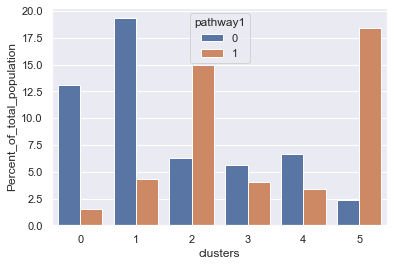

In [40]:
lisinopril_count=df_1.groupby(['clusters','pathway1'])['pathway1'].agg(['count']).reset_index()

lisinopril_count['Percent_of_total_population'] = 100 * lisinopril_count['count'] / lisinopril_count['count'].sum()
print(lisinopril_count)
ax = sns.barplot(x="clusters", y="Percent_of_total_population", data=lisinopril_count,hue="pathway1")



    clusters  dead_alive  count  Percent_of_total_population
0          0           0    127                     4.691540
1          0           1    270                     9.974141
2          1           0    580                    21.425933
3          1           1     61                     2.253417
4          2           0    547                    20.206871
5          2           1     26                     0.960473
6          3           0    183                     6.760251
7          3           1     79                     2.918360
8          4           0     82                     3.029184
9          4           1    190                     7.018840
10         5           0     75                     2.770595
11         5           1    487                    17.990395


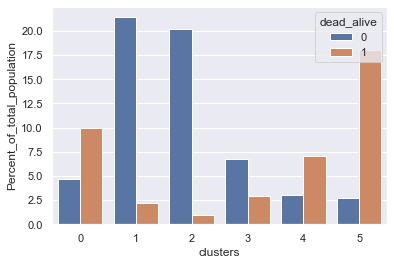

In [41]:
Alive_count=df_1.groupby(['clusters','dead_alive'])['dead_alive'].agg(['count']).reset_index()
Alive_count['Percent_of_total_population'] = 100 * Alive_count['count'] / Alive_count['count'].sum()
print(Alive_count)
ax = sns.barplot(x="clusters", y="Percent_of_total_population", data=Alive_count,hue="dead_alive")
plt.gcf().savefig('try.png')

    clusters  diabetes_pathway  count  Percent_of_total_population
0          0                 0    381                    14.074621
1          0                 1     16                     0.591060
2          1                 0    641                    23.679350
3          2                 0    555                    20.502401
4          2                 1     18                     0.664943
5          3                 0      1                     0.036941
6          3                 1    261                     9.641670
7          4                 0    257                     9.493905
8          4                 1     15                     0.554119
9          5                 0    513                    18.950868
10         5                 1     49                     1.810122


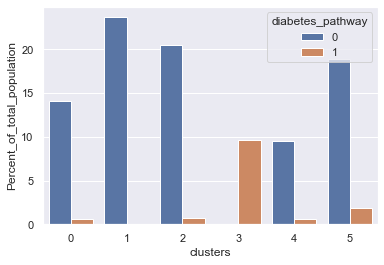

In [42]:
diabetes_count=df_1.groupby(['clusters','diabetes_pathway'])['diabetes_pathway'].agg(['count']).reset_index()
diabetes_count['Percent_of_total_population'] = 100 * diabetes_count['count'] / diabetes_count['count'].sum()
print(diabetes_count)
ax = sns.barplot(x="clusters", y="Percent_of_total_population", data=diabetes_count,hue="diabetes_pathway")


    clusters  hypertention_pathway  count  Percent_of_total_population
0          0                     0    330                    12.190617
1          0                     1     67                     2.475065
2          1                     0    112                     4.137421
3          1                     1    529                    19.541928
4          2                     0    418                    15.441448
5          2                     1    155                     5.725896
6          3                     0    103                     3.804950
7          3                     1    159                     5.873661
8          4                     0     52                     1.920946
9          4                     1    220                     8.127078
10         5                     0     91                     3.361655
11         5                     1    471                    17.399335


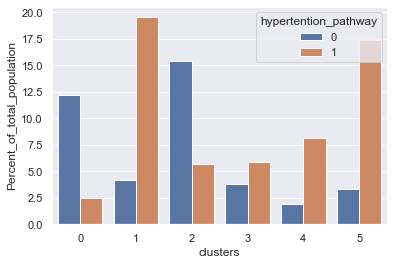

In [43]:
hypertention_count=df_1.groupby(['clusters','hypertention_pathway'])['hypertention_pathway'].agg(['count']).reset_index()
hypertention_count['Percent_of_total_population'] = 100 * hypertention_count['count'] / hypertention_count['count'].sum()
print(hypertention_count)
ax = sns.barplot(x="clusters", y="Percent_of_total_population", data=hypertention_count,hue="hypertention_pathway")


    clusters  hyperlipidemia_pathway  count  Percent_of_total_population
0          0                       0    329                    12.153676
1          0                       1     68                     2.512006
2          1                       0    227                     8.385667
3          1                       1    414                    15.293683
4          2                       0    489                    18.064278
5          2                       1     84                     3.103066
6          3                       0    139                     5.134836
7          3                       1    123                     4.543775
8          4                       0     84                     3.103066
9          4                       1    188                     6.944958
10         5                       0    105                     3.878833
11         5                       1    457                    16.882157


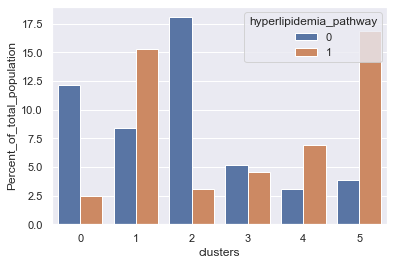

In [44]:
hyperlipidemia_count=df_1.groupby(['clusters','hyperlipidemia_pathway'])['hyperlipidemia_pathway'].agg(['count']).reset_index()

hyperlipidemia_count['Percent_of_total_population'] = 100 * hyperlipidemia_count['count'] / hyperlipidemia_count['count'].sum()
print(hyperlipidemia_count)
ax = sns.barplot(x="clusters", y="Percent_of_total_population", data=hyperlipidemia_count,hue="hyperlipidemia_pathway")




## Logistric Regression 

In [45]:
# LOGISTIC REGRESSION - HOW DATASET LOOKS LIKE 

In [46]:
type(df_1)

pandas.core.frame.DataFrame

In [47]:
df_1.columns

Index(['person_id', 'pathway1', 'diastolic_bp', 'systolic_bp', 'age', 'gender',
       'weight', 'dead_alive', 'diabetes_pathway', 'hypertention_pathway',
       'hyperlipidemia_pathway', 'clusters'],
      dtype='object')

In [48]:
print('0=without the condition ; 1=with the condition')
print(df_1['diabetes_pathway'].value_counts()) 
print(df_1['hyperlipidemia_pathway'].value_counts())
print(df_1['hypertention_pathway'].value_counts())

0=without the condition ; 1=with the condition
0    2348
1     359
Name: diabetes_pathway, dtype: int64
0    1373
1    1334
Name: hyperlipidemia_pathway, dtype: int64
1    1601
0    1106
Name: hypertention_pathway, dtype: int64


In [49]:
# Visualization of few data points 

Text(0, 0.5, 'number of patients')

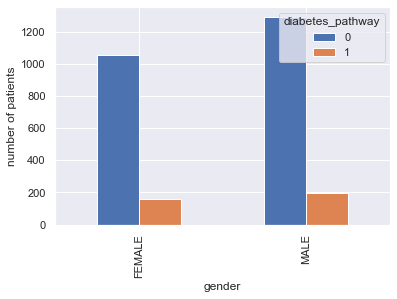

In [50]:
# below visualization shows patients with annd withoout diabetes based on gender 
%matplotlib inline
pd.crosstab(df_1.gender,df_1.diabetes_pathway).plot(kind='bar')
plt.xlabel('gender')
plt.ylabel('number of patients')

Text(0, 0.5, 'number of patients')

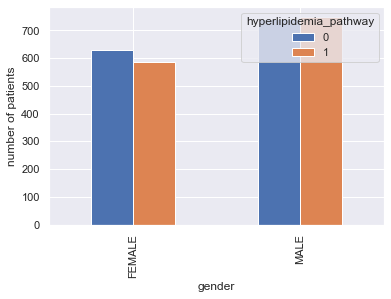

In [51]:
# below visualization shows patients with annd withoout hyperlipidemia based on gender 
%matplotlib inline
pd.crosstab(df_1.gender,df_1.hyperlipidemia_pathway).plot(kind='bar')
plt.xlabel('gender')
plt.ylabel('number of patients')

Text(0, 0.5, 'number of patients')

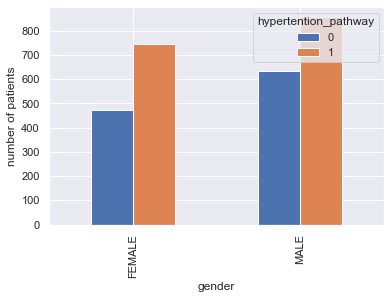

In [52]:
# below visualization shows patients with and withoout hypertention based on gender 
%matplotlib inline
pd.crosstab(df_1.gender,df_1.hypertention_pathway).plot(kind='bar')
plt.xlabel('gender')
plt.ylabel('number of patients')

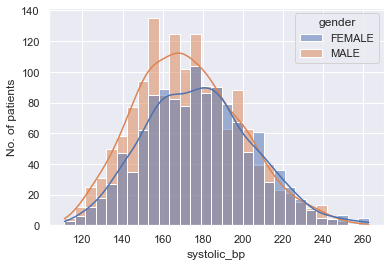

In [53]:
# below visualization shows patients systolic blood pressure based on gender
CHF1 = df_1.drop(df_1[df_1.systolic_bp >500].index)
sns.histplot(x='systolic_bp', data=CHF1, kde=True, hue='gender')
plt.xlabel('systolic_bp')
plt.ylabel('No. of patients')
  
plt.show()

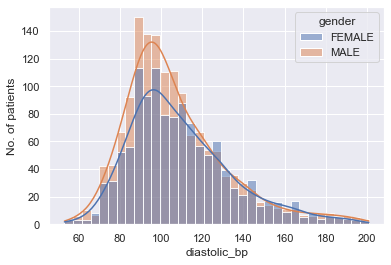

In [54]:
# below visualization shows patients diastolic blood pressure based on gender
CHF2 = df_1.drop(df_1[df_1.diastolic_bp >300].index)
sns.histplot(x='diastolic_bp', data=CHF2, kde=True, hue='gender')
plt.xlabel('diastolic_bp')
plt.ylabel('No. of patients')
  
plt.show()

In [55]:
# SHOWING THE MEAN FOR EACH CONDITION ACROSS THE TABLE 

In [56]:
df_1.groupby('diabetes_pathway').mean()

,person_id,pathway1,diastolic_bp,systolic_bp,age,weight,dead_alive,hypertention_pathway,hyperlipidemia_pathway,clusters
diabetes_pathway,,,,,,,,,,
0,3.927974e+08,0.458262,107.783646,174.204855,72.568995,89.947832,0.406729,0.600511,0.484668,2.277257
1,3.927964e+08,0.526462,109.807799,181.696379,68.470752,94.397521,0.440111,0.532033,0.545961,3.130919


In [57]:
df_1.groupby('hyperlipidemia_pathway').mean()

,person_id,pathway1,diastolic_bp,systolic_bp,age,weight,dead_alive,diabetes_pathway,hypertention_pathway,clusters
hyperlipidemia_pathway,,,,,,,,,,
0,3.927957e+08,0.398398,108.352513,175.621996,71.426803,89.577422,0.313183,0.118718,0.510561,1.808449
1,3.927989e+08,0.538231,107.742879,174.762369,72.641679,91.526552,0.511994,0.146927,0.674663,2.989505


In [58]:
df_1.groupby('hypertention_pathway').mean()

,person_id,pathway1,diastolic_bp,systolic_bp,age,weight,dead_alive,diabetes_pathway,hyperlipidemia_pathway,clusters
hypertention_pathway,,,,,,,,,,
0,3.927976e+08,0.387884,107.000904,173.387884,71.137432,89.674069,0.354430,0.151899,0.392405,1.735986
1,3.927970e+08,0.522174,108.778264,176.449094,72.638976,91.134728,0.450344,0.119300,0.562149,2.842598


In [59]:
# dividing the data into training and test sets

In [60]:
#split dataset in features and target variable
feature_cols = ['pathway1','diastolic_bp','systolic_bp','age','weight']
x = df_1[feature_cols] # Features
y = df_1.hypertention_pathway # Target variable

In [61]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=0)

In [62]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(x_train,y_train)

#
y_pred=logreg.predict(x_test)

In [63]:
# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[ 49, 188],
       [ 27, 278]])

Text(0.5, 257.44, 'Predicted label')

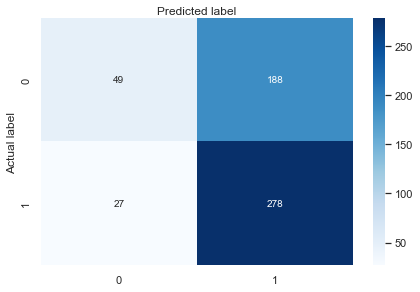

In [67]:
# Development of heat map shows actual and predicted value
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Blues" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [69]:
# Getting accuracy of our prediction and development of ROC curve

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.6033210332103321
Precision: 0.5965665236051502
Recall: 0.9114754098360656


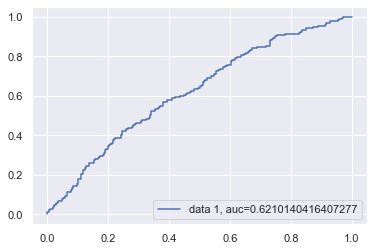

In [70]:
y_pred_proba = logreg.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()